# First Order Ego Graph Analysis on Twitter User @PietroMonticone

In this notebook we analyze the second order ego graph of a Twitter account with $\sim10^3$ followees.

## Modules

In [1]:
# Enable interactive numpy and matplotlib
%pylab inline

# Data Wrangling 
import pandas as pd
import numpy as np

# Data Analysis
import powerlaw as pwl

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

# Network Analysis 
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.centrality as nc
import social_physics as soc

# Network Epidemiology 
import EoN

# Data Visualization
import seaborn as sns
from netwulf import visualize

# Other Utilities 
import sys, os, os.path
import itertools
from progressbar import ProgressBar, Bar, Percentage
from operator import itemgetter
from collections import Counter
from collections import defaultdict
import random

# Reload Custom Modules
from importlib import reload
soc = reload(soc)

Populating the interactive namespace from numpy and matplotlib


## Graph Data Collection

Load the graph as a edge list outputted by scraping libraries as `tweepy` or `rtweet`. 

A custom function `rtweet_to_networkx` has been written for this purpose.

In [2]:
# Import the csv files for the first and second order egonetwork data 
fo = "./Data/EdgeLists/pietro_friends.csv"
so =  "./Data/EdgeLists/pietro.csv"

# Convert rtweet output (.csv) to a networkx graph object
G = soc.rtweet_to_networkx(fo, so)

# Rename the graph 
G.name = "Twitter 1st Order Followee EgoGraph"

# Show the basic attributes of the graph
print(nx.info(G))

# Relable the nodes (from strings of Twitter IDs to integers)
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

Name: Twitter 1st Order Followee EgoGraph
Type: DiGraph
Number of nodes: 1177
Number of edges: 54166
Average in degree:  46.0204
Average out degree:  46.0204


## Graph Data Visualization 

```python 
visualize(G)
```

![](./Images/Twitter/@PietroMonticone1NW.png)

## Graph Data Analysis 

We proceed by visualizing the normalized degree distributions.

### Undirected Degree Distribution

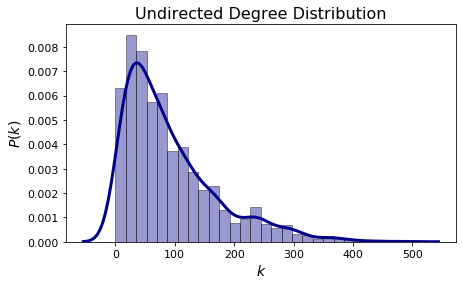

Mean =  92.04078164825829 
Var =  6195.66018902369


In [3]:
# Get undirected degree distribution 
undirected_degree_distribution, degree_mean, degree_variance = soc.get_degree_distribution(G, "degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot undirected degree distribution 
soc.plot_degree_distribution(undirected_degree_distribution, 
                             title = "Undirected Degree Distribution", 
                             log = False, 
                             display_stats = True)

# Show mean and variance of the undirected degree distribution 
print("Mean = ", degree_mean,"\nVar = ", degree_variance)

### In-Degree Distribution

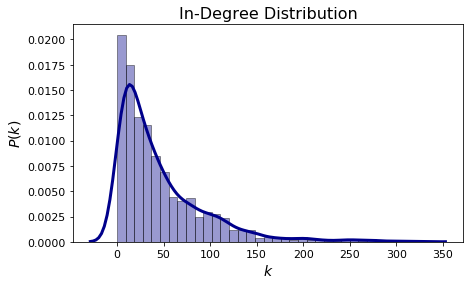

Mean =  46.020390824129144 
Var =  2305.0259223621247


In [4]:
# Get in-degree distribution 
in_degree_distribution, indegree_mean, indegree_variance = soc.get_degree_distribution(G, "in_degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot in-degree distribution 
soc.plot_degree_distribution(in_degree_distribution, 
                             title = "In-Degree Distribution",
                             log_binning = None, 
                             display_stats = True)

# Show mean and variance of the in-degree degree distribution 
print("Mean = ",indegree_mean,"\nVar = ", indegree_variance)

### Out-Degree Distribution

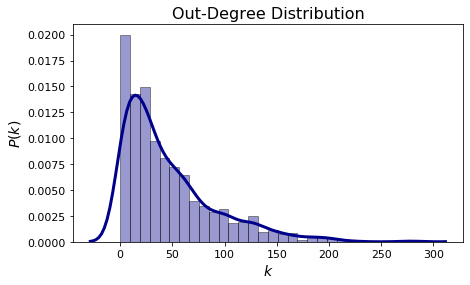

Mean =  46.020390824129144 
Var =  1939.9231186238067


In [5]:
# Get out-degree distribution 
out_degree_distribution, outdegree_mean, outdegree_variance = soc.get_degree_distribution(G, "out_degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot out-degree distribution 
soc.plot_degree_distribution(out_degree_distribution, 
                             title = "Out-Degree Distribution",
                             log_binning = None, 
                             display_stats = True)

# Show mean and variance of the out-degree degree distribution 
print("Mean = ",outdegree_mean,"\nVar = ", outdegree_variance)

As expected $\langle k_{in}\rangle = \langle k_{out}\rangle$. 

### Logarithmic Binning
The black line is the empirical linearly binned pdf. 

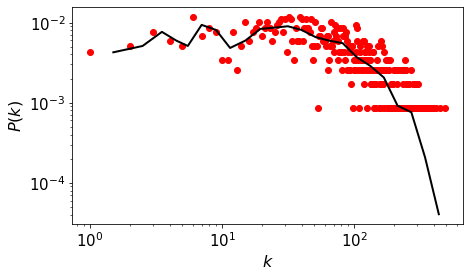

In [6]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot
pwl_distribution = soc.power_law_plot(graph = G, log = True, linear_binning = False, bins = 1000, draw = True)

The empirical PDF doesn't interpolate because it is obtained via linear binning while the red data points represent the logarithmic binning.

### Linear Binning

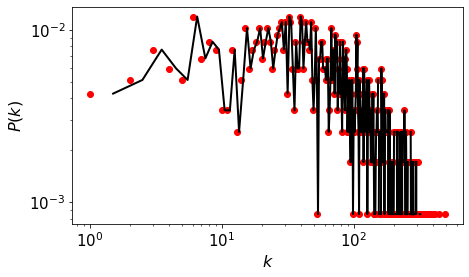

In [7]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot 
pwl_distribution = soc.power_law_plot(graph = G, log = True, linear_binning = True, bins = 1000, draw = True)

The figure above interpolates because it uses linear binnig both for scatter plot and pdf binning. 

### Power Law Fitting 

#### Parameters Estimation

Here we estimate the measure to which the network follows a power law, and compare it with other common distributions.

In [8]:
fit_function = pwl.Fit(list(undirected_degree_distribution.values()))

print("Exponent = ", fit_function.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function.power_law.sigma)
xmin = fit_function.power_law.xmin
print("x_min = ",xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Exponent =  5.762932820867833
Sigma (error associated to exponent) =  0.4693057158330723
x_min =  224.0
Kolmogorov-Smirnov distance =  0.08670972068822691


Because the fitted $x_{min} = 224$, let's require it to be a little higher prior to fitting.

In [9]:
fit_function_fix_xmin = pwl.Fit(list(undirected_degree_distribution.values()),xmin= 25) 
print("Exponent = ", fit_function_fix_xmin.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function_fix_xmin.power_law.sigma)
print("x_min = ",fit_function_fix_xmin.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function_fix_xmin.power_law.D)

Exponent =  1.8104363398114864
Sigma (error associated to exponent) =  0.02591489652396259
x_min =  25.0
Kolmogorov-Smirnov distance =  0.19024068027258967


Values less than or equal to 0 in data. Throwing out 0 or negative values


Now the error (sigma) is way lower than before, but Kolmogorov-Smironv is higher as expected (because we fixed $x_{min}$ prior to fitting so we have lowered the degrees of freedom by one). Thus we confirmed that a power law fitting is good only near the tail because $x_{min} = 224$.<br>
Let us now compare the actual PDF with the fitted power law near the tail.<br>
<span style="color:blue">**BLUE**</span> : Fitted power law. <br>
<span style="color:black">**BLACK**</span> : Plotted PDF.

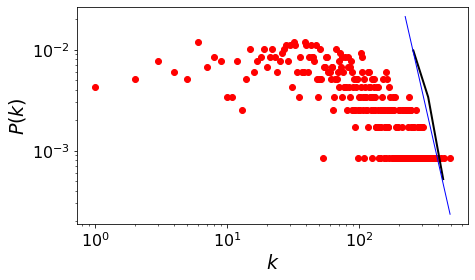

In [10]:
# Set figure size
plt.figure(figsize=(7,4))

pwl_distribution = soc.power_law_plot(graph = G, log = True, linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$k$', fontsize=19)
plt.ylabel('$P(k)$', fontsize=19)
plt.show()

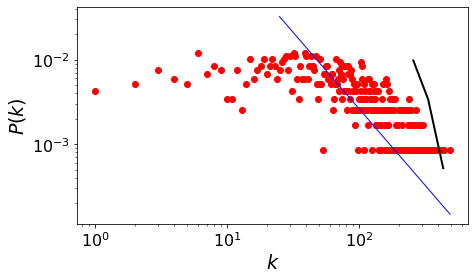

In [11]:
# Set figure size
plt.figure(figsize=(7,4))

#plt.plot(x,y,'ro')

pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function_fix_xmin.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

#fig.legend(fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$k$', fontsize=19)
plt.ylabel('$P(k)$', fontsize=19)
plt.show()

Let us now compare power law against other probability distributions. Remember that $R$ is the log-likelihood ratio between the two candidate distributions which will be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. The significance value for that direction is $p$. 

In [12]:
R,p = fit_function.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-2.1446486912746705, 0.03198094611143203)

In [13]:
R,p = fit_function.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R,p

(-1.4716624500196898, 0.14111205238691252)

In [14]:
R,p = fit_function.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
R,p

Assuming nested distributions


(-2.3534401113321772, 0.029285932568189676)

In [15]:
R,p = fit_function.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
R,p

(-1.5314913118817675, 0.12564801203959136)

Let us also compare with the truncated power law:

In [16]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

(-15.468448547303739, 5.665609795391773e-54)

In [17]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True) 
R,p

(-13.071734116325459, 4.7764114894695364e-39)

In [18]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True) 
R,p

(-14.076530240167434, 5.29462719874679e-45)

## Centrality Metrics 

We compute and visualize the portfolio of centrality metrics.

### Degree

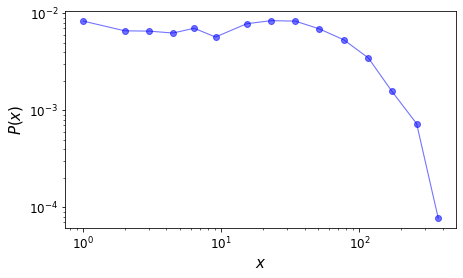

In [19]:
# Get degree centrality 
degree_centrality = soc.get_centrality(G, "degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, degree_centrality, "Blue", 15)

### Closeness

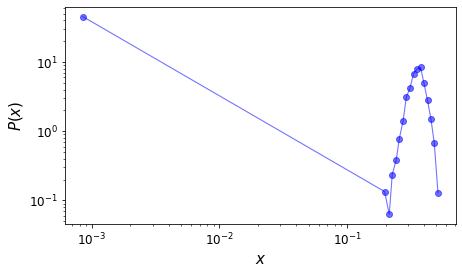

In [20]:
# Get closeness centrality (computationally intensive!)
closeness_centrality = soc.get_centrality(G, "closeness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, closeness_centrality, "Blue", 100)

### Betweenness

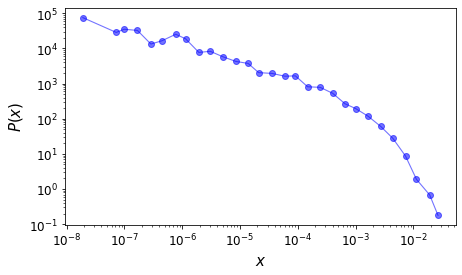

In [21]:
# Get degree centrality 
betweenness_centrality = soc.get_centrality(G, "betweenness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, betweenness_centrality, "Blue", 30)

### Eigenvector

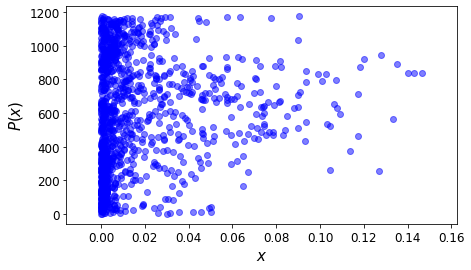

In [22]:
# Get degree centrality 
eigenvector_centrality = soc.get_centrality(G, "eigenvector")

# Set figure size
plt.figure(figsize=(7,4))

x_centrality=[]
y_centrality=[]
     
for i in eigenvector_centrality:
    x_centrality.append(i[0])
    y_centrality.append(i[1])

plt.scatter(x_centrality,y_centrality, color="Blue", marker="o",alpha=0.50) 
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$x$', fontsize = 15)
plt.ylabel('$P(x)$', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Katz

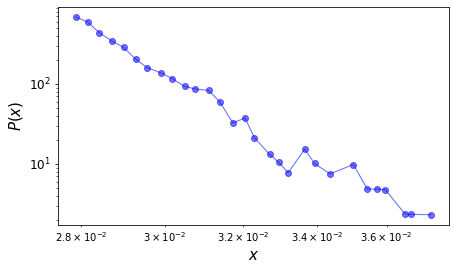

In [23]:
# Get degree centrality 
katz_centrality = soc.get_centrality(G, "katz")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, katz_centrality, "Blue", 30)

### PageRank
$$x_i=(1-\alpha) \sum_{j}A^{T}_{ij}\frac{x_j}{k^{out}_j}+\frac{\alpha}{N}$$

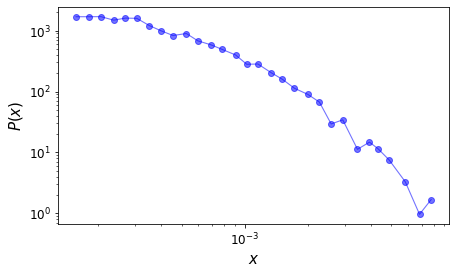

In [24]:
# Get degree centrality 
pagerank_centrality = soc.get_centrality(G, "pagerank")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, pagerank_centrality, "Blue", 30)

## Connectivity 

Here we explore the connectivity of the graph.

In [25]:
# Show the connectivity of the analyzed graph
print("The graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(),"edges.")
print("Is the (directed) graph weakly connected?", nx.is_weakly_connected(G),".")  
print("Is the (directed) graph strongly connected?", nx.is_strongly_connected(G),".")
G_weakly_cc = list(nx.weakly_connected_components(G))
print("The graph has", len(G_weakly_cc),"weakly connected components.")
print("The sizes of the weakly connected components are", [len(c) for c in sorted(G_weakly_cc, key=len, reverse=True)],".")
G_strongly_cc = list(nx.strongly_connected_components(G))
print("The graph has", len(G_strongly_cc),"strongly connected components.")
print("The sizes of the strongly connected components are", [len(c) for c in sorted(G_strongly_cc, key=len, reverse=True)],".")

The graph has 1177 nodes and 54166 edges.
Is the (directed) graph weakly connected? False .
Is the (directed) graph strongly connected? False .
The graph has 3 weakly connected components.
The sizes of the weakly connected components are [1175, 1, 1] .
The graph has 55 strongly connected components.
The sizes of the strongly connected components are [1120, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] .


## Clustering 

Here we compute the **average clustering coefficient** and the **global clustering coefficient**.

In [26]:
# Consider the undirected version (G -> U)
U = G.to_undirected()

# Rename the undirected graph 
U.name = "Twitter Undirected EgoGraph"

# Show the basic attributes of U vs. G 
print(nx.info(U), "\n")
print(nx.info(G))

Name: Twitter Undirected EgoGraph
Type: Graph
Number of nodes: 1177
Number of edges: 42082
Average degree:  71.5072 

Name: Twitter 1st Order Followee EgoGraph
Type: DiGraph
Number of nodes: 1177
Number of edges: 54166
Average in degree:  46.0204
Average out degree:  46.0204


### Global Clustering Coefficient

The global clustering coefficient measures the number of triangles in the network and it's defined as

$$ C_\Delta = \frac{3 \times \text{triangles}}{\text{triplets}} $$

In order to compare our graph with theorical models (of the same size), it is thus sufficient to evaluate the number of triangles.

In [27]:
# Compute the global clustering coefficient of U (the fraction of all possible triangles in the network)
print("Global clustering coefficient = ", nx.transitivity(G))

Global clustering coefficient =  0.2767705719605647


### Average Clustering Coefficient

The overall level of clustering in a network is measured by Watts and Strogatz as the average of the local clustering coefficients of all the vertices $n$:

$$\bar{C} = \frac{1}{n}\sum_{i=1}^{n} C_i.$$


It is worth noting that this metric places more weight on the low degree nodes, while the transitivity ratio places more weight on the high degree nodes. In fact, a weighted average where each local clustering score is weighted by $k_i(k_i-1)$ is identical to the global clustering coefficient. <br> As per [this](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html) and [this](https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/cluster.html ) resources we notice that Networkx's `average_clustering` function automatically takes care of the network being directed or not.

In [28]:
G_avg_cc =  nx.average_clustering(G)
print("The average clustering coefficient is ",G_avg_cc) 

The average clustering coefficient is  0.318741275646453


## Path-ology  

### Average Shortest Path Length

In [29]:
#print("The average shortest path length is ", nx.average_shortest_path_length(G),"") # Graph is not weakly connected.

average_degree = sum(list(dict(G.degree()).values()))/len(G.degree())
GWCC = list(G_weakly_cc[0])

print("Since the graph is not weakly connected, but one of its 3 weakly connected compoments amounts for ",len(GWCC)/len(G), "of the nodes count, we approximate its averaege shortest path length with that of its bigger weakly connected component, which is:", nx.average_shortest_path_length(G.subgraph(GWCC)), "\nLet's compare it with lnlnN = ", math.log(math.log(len(GWCC))), "(ultra small world)\nand with lnN/lnlnN = ", math.log(len(GWCC))/math.log(math.log(len(GWCC))), "(equivalent to a power law with exponent 3)\nand with lnN = ", math.log(len(GWCC))/math.log(average_degree), "equivalent to a random network.")

Since the graph is not weakly connected, but one of its 3 weakly connected compoments amounts for  0.9983007646559049 of the nodes count, we approximate its averaege shortest path length with that of its bigger weakly connected component, which is: 2.5764268367827756 
Let's compare it with lnlnN =  1.9557223411709137 (ultra small world)
and with lnN/lnlnN =  3.614533248286131 (equivalent to a power law with exponent 3)
and with lnN =  1.5631714174475957 equivalent to a random network.


## Comparisons with Random Models 

### G vs. ER

The most natural benchmark is a ER (random) network with the same number of nodes and links. In a ER network, the $p_k$ is Poissonian (an exponential decay), so let's compare G with random **Erdos-Renyi** graph with the same average connectivity and number of nodes.

In [30]:
nnodes = U.number_of_nodes()
nedges = U.number_of_edges()
plink = 2*nedges/(nnodes*(nnodes-1)) # 2* because it is undirected

ER = nx.fast_gnp_random_graph(nnodes, plink)

average_degree = sum(list(dict(ER.degree()).values()))/len(ER.degree())

# Connectivity
print("The ER graph has", len(ER), "nodes", "and",len(ER.edges()),"edges.\n The difference between its maximum and minimun degree is:",max(list(dict(ER.degree).values()))-min(list(dict(ER.degree).values())),", while the sane difference in our network is:", max(list(dict(U.degree).values()))-min(list(dict(U.degree).values())),"which is higher, confirming that real nertworks are not random.")

# Test connectedness
print("Is the ER graph simply connected ?", nx.is_connected(ER), ". Infact the average degree is:",
      average_degree,"and the natural log of the number of nodes is", 
      math.log(nnodes),"which is smaller, then we are in the connected regime.")

# Average clustering coefficient
print("The average clustering coefficient of ER is", nx.average_clustering(ER),"which, if compared with <k>/N", average_degree/(nnodes), "we can observe they are similar as expected. But it is approximately one order of magnitude less than the egonetwork's one ")

print("The transitivity of the network is", nx.transitivity(ER))

# Average shortest path
print("The ER graph is small world since the average shortest path is", nx.average_shortest_path_length(ER),"which we compare with lnN/ln(<k>):" ,math.log(nnodes)/math.log(average_degree),"to check the small world effect", "\nand the expected result is lnN/ln(<k>):", math.log(len(ER))/math.log(average_degree))

The ER graph has 1177 nodes and 41933 edges.
 The difference between its maximum and minimun degree is: 51 , while the sane difference in our network is: 329 which is higher, confirming that real nertworks are not random.
Is the ER graph simply connected ? True . Infact the average degree is: 71.25403568394222 and the natural log of the number of nodes is 7.0707241072602764 which is smaller, then we are in the connected regime.
The average clustering coefficient of ER is 0.06037906074376835 which, if compared with <k>/N 0.060538687921786086 we can observe they are similar as expected. But it is approximately one order of magnitude less than the egonetwork's one 
The transitivity of the network is 0.06039592976665636
The ER graph is small world since the average shortest path is 1.9517307347747934 which we compare with lnN/ln(<k>): 1.6573622477885972 to check the small world effect 
and the expected result is lnN/ln(<k>): 1.6573622477885972


#### G vs. AB

Thinking about  a broad (not exponential decaying) distribution, more like a power law, we may think about a AB network (Albert-Barabasi), so let's compare G with random **Albert-Barabasi** graph with the same average connectivity and number of nodes. 

In [31]:
n = U.number_of_nodes()
m = int(U.number_of_edges() / n + 0.5) # 0.5 added to correctly round

AB = nx.barabasi_albert_graph(n,m)

# Test connectedness
print("Is the AB graph simply connected ?", nx.is_connected(AB))
# Connectivity
print("The AB graph has", len(AB), "nodes", "and",len(AB.edges()),"edges ..\n The difference between its maximum and minimun degree is:",max(list(dict(AB.degree).values()))-min(list(dict(AB.degree).values())), ", while the sane difference in our network is:", max(list(dict(U.degree).values()))-min(list(dict(U.degree).values())), "which is similar, confirming that albert barabasi captures the fundamental mechanisms that underly real network formation better than a random network would.")

# Average clustering coefficient
print("The average clustering coefficient of AB is", nx.average_clustering(AB),". We may compare it with the predicted C_l = (m*ln(N)^2)/(4*N) = ",(m*(math.log(n))**2)/(4*n),"while the global clustering coefficient is: ",nx.transitivity(AB),".")

# Average shortest path
print("The AB graph is small world since the average shortest path is", nx.average_shortest_path_length(AB),"and the expected result is lnN/lnlnN", math.log(len(AB))/math.log(math.log(len(AB))))

Is the AB graph simply connected ? True
The AB graph has 1177 nodes and 41076 edges ..
 The difference between its maximum and minimun degree is: 345 , while the sane difference in our network is: 329 which is similar, confirming that albert barabasi captures the fundamental mechanisms that underly real network formation better than a random network would.
The average clustering coefficient of AB is 0.12775698912082864 . We may compare it with the predicted C_l = (m*ln(N)^2)/(4*N) =  0.3822907855640822 while the global clustering coefficient is:  0.12566508401965612 .
The AB graph is small world since the average shortest path is 1.9742094798837122 and the expected result is lnN/lnlnN 3.6149582017347894


Let's verify that an AB network follows a power law distribution.

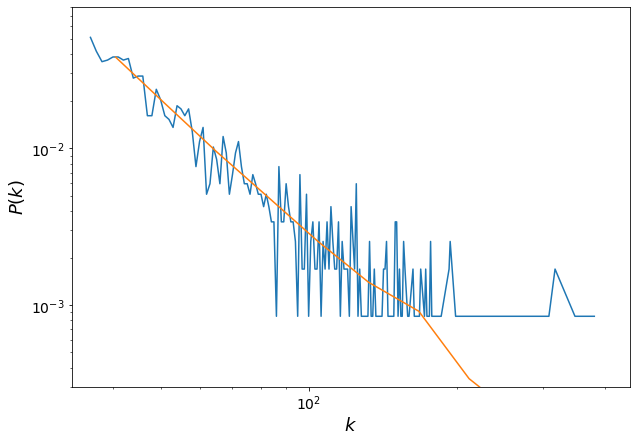

alpha =  1.5871933123166673
sigma =  0.01711562920203825
x_min =  11.0
Kolmogorov-Smirnov distance =  0.5015192406411231


In [32]:
# Create the degree distribution
AB_degree = dict(AB.degree()).values()
AB_degree_distribution = Counter(AB_degree)

# Plot the degree frequency distribution & 
# the probability density function 
plt.figure(figsize=(10,7))
x=[]
y=[]
for i in sorted(AB_degree_distribution):   
    x.append(i)
    y.append(float(AB_degree_distribution[i])/len(AB))

plt.plot(np.array(x),np.array(y))
pwl.plot_pdf(list(AB_degree))

plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.axis([33,450,0.0003,0.08])
plt.show()

# Fit the degree distribution with a power law
fit_function = pwl.Fit(list(AB_degree), xmin=11)

# Output parameters
print("alpha = ",fit_function.power_law.alpha)
print("sigma = ",fit_function.power_law.sigma)
print("x_min = ",fit_function.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

#### G vs. WS

A Watts-Strogatz graph combines small world (short average shortest path) with high clustering coefficient. This model starts from a lattice where each node is connected to its $d$ nearest neighbors,. and then with probability $r = 0.2$ each link is detached from one end and reformed with another random node.
Let's compare G with random **Watts-Strogatz** graph with the same average connectivity and number of nodes.<br>

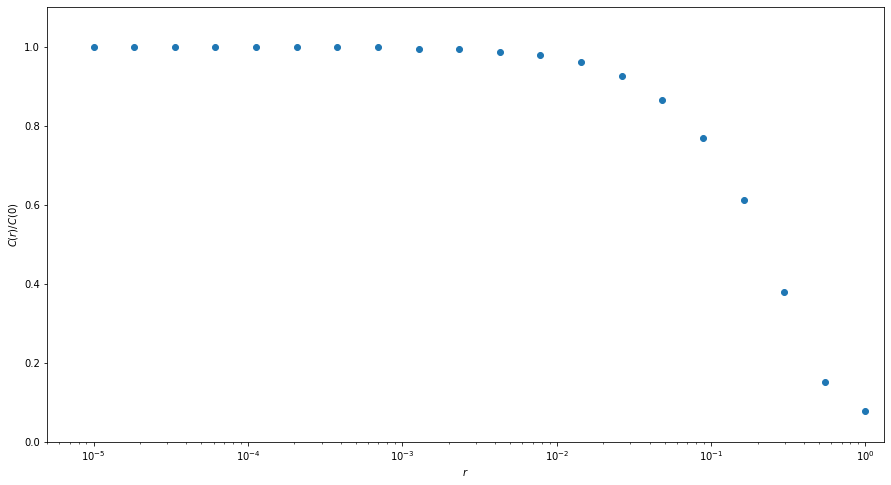

best rewiring rate =  0.2976351441631319 
best_avg_cc =  0.2811765801051978 ( 0.03756469554125519 apart from G's one)


In [33]:
#let's find the rewiring rate r that best approximates G, in terms of average clustering coefficient.
n = U.number_of_nodes()                              # nodal cardinality
d = 2*int(U.number_of_edges() / U.number_of_nodes())
avg_clust_coeffs_ws = []
r_log_list = numpy.logspace(-5, 0, num=20, endpoint=True, base=10.0, dtype=None, axis=0)
#print(r_list)
runs = 50
for r in r_log_list:
    WS = nx.connected_watts_strogatz_graph(n, d, r, runs)
    #WS = nx.watts_strogatz_graph(n, d, r)
    avg_clust_coeffs_ws.append(nx.average_clustering(WS))
    #print("done 1")
   
avg_clust_coeffs_ws_norm = [avg_clust_coeffs_ws[i]/avg_clust_coeffs_ws[0] for i in range(len(avg_clust_coeffs_ws))]

plt.scatter(r_log_list,avg_clust_coeffs_ws_norm , marker = "o")
plt.xscale("log")
plt.xlabel("$r$")
plt.axis([0.000005,1.32,0,1.1])
plt.ylabel("$C(r)/C(0)$")
plt.title("")
plt.show()

#find r value that best approximates G (in terms ofclustering coefficient; we couldn't choose the best compromise between average clustering coefficient and average shortest distance because the latter wouldhave taken too much time to evaluate for all r's)
best_avg_cc = avg_clust_coeffs_ws[np.argmin([abs(avg_clust_coeffs_ws[i]-G_avg_cc) for i in range(len(avg_clust_coeffs_ws))])]
best_r  = r_log_list[np.argmin([abs(avg_clust_coeffs_ws[i]-G_avg_cc) for i in range(len(avg_clust_coeffs_ws))])]

print("best rewiring rate = ",best_r, "\nbest_avg_cc = ",best_avg_cc ,"(",abs(best_avg_cc-G_avg_cc),"apart from G's one)")

In [34]:
# Input parameters
r = best_r

WS = nx.connected_watts_strogatz_graph(n, d, r, runs)

# Test connectedness
print("Is the WS graph simply connected ?", nx.is_connected(WS))

# Connectivity
print("The WS graph has", WS.number_of_nodes(), "nodes", "and",WS.number_of_edges(),"edges .") 

# Average clustering coefficient
print("The average clustering coefficient of WS is", nx.average_clustering(WS))

# Total number of triangles 
print("The global clustering coefficient is", nx.transitivity(WS))

# Average shortest path
print("The WS graph has average shortest path  = ", nx.average_shortest_path_length(WS),".")

Is the WS graph simply connected ? True
The WS graph has 1177 nodes and 41195 edges .
The average clustering coefficient of WS is 0.2754924181313069
The global clustering coefficient is 0.2741815718784248
The WS graph has average shortest path  =  2.0313419335448706 .


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text yticklabel objects>)

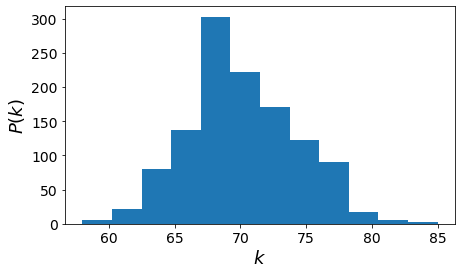

In [35]:
# Extract the degree distribution 
ws_degrees = (dict(WS.degree()).values())

# Plot the degree frequency distribution
plt.figure(figsize=(7,4))
plt.hist(ws_degrees, bins=12)
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Degree Assortativity of a Network

A network is assortative with respect to a feature/features if nodes with similar feature(s) values are more often connected between them rather then with nodes having different feature(s) values.<br>
The degree assortativity is assortativity with respect to degree: are nodes with similar degree more connected between themselves than with nodes with different degree?<br>
Degree assortativity can be measured in different ways. Using scalar assortativity theory we get the following quantities:

In [36]:
# degree assortativity can also be computed with nx's functions
# Compute the degree assortativity coefficient of G and ER
dac_G = nx.degree_assortativity_coefficient(G) # this is the pearson correlation coefficient of the red dots of the plot above. Infact, for the ER network it is close to zero, since in a ER network nodes are likely to connect regardless of their degree.
dac_ER = nx.degree_assortativity_coefficient(ER)
dac_AB = nx.degree_assortativity_coefficient(AB)
dac_WS = nx.degree_assortativity_coefficient(WS)

print("The degree assortativity coefficient of G is", dac_G, 
      "\nwhile the degree assortativity coeffiecient of a ER graph is", dac_ER,
      "\nwhile the degree assortativity coeffiecient of a AB graph is" ,dac_AB,
      "\nwhile the degree assortativity coeffiecient of a WS graph is" ,dac_WS,)

# Compute the Pearson / linear correlation coefficient with nx function
pcc_G = nx.degree_pearson_correlation_coefficient(G)
pcc_ER = nx.degree_pearson_correlation_coefficient(ER)
pcc_AB = nx.degree_pearson_correlation_coefficient(AB)
pcc_WS = nx.degree_pearson_correlation_coefficient(WS)

print("The Pearson correlation coefficient of G is", pcc_G, 
      "\nwhile the Pearson correlation coeffiecient of a ER graph is", pcc_ER,
      "\nwhile the Pearson correlation coeffiecient of a AB graph is" ,pcc_AB,
      "\nwhile the Pearson correlation coeffiecient of a WS graph is" ,pcc_WS,)

The degree assortativity coefficient of G is -0.03672077349954983 
while the degree assortativity coeffiecient of a ER graph is 0.0007552029016937323 
while the degree assortativity coeffiecient of a AB graph is -0.011077254851466219 
while the degree assortativity coeffiecient of a WS graph is -0.004017538834272489
The Pearson correlation coefficient of G is -0.036720773499548734 
while the Pearson correlation coeffiecient of a ER graph is 0.0007552029016997244 
while the Pearson correlation coeffiecient of a AB graph is -0.011077254851466102 
while the Pearson correlation coeffiecient of a WS graph is -0.004017538834259773


Anyway, this approach does not take into consideration possible nonlinear degree correlations.
A less powerful but more general approach would be to measure the average nearest neighbor degree per degree class, in order to determine a possible trend and to compare it with the expected average nearest neighbor degree per degree class if the network is uncorrelated, in which case:

$$ k_{nn}^{unc}(k) = \frac{\langle k^2 \rangle}{\langle k \rangle}$$

k_unc =  159.35507513938634


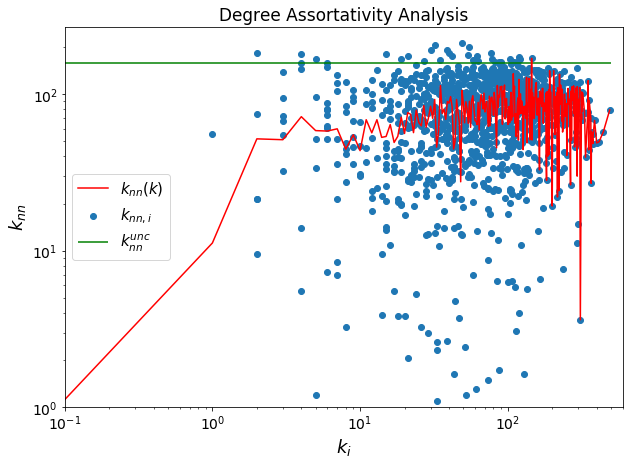

In [37]:
# Compute the average nearest neighbour degree for all the nodes in G 
x=[]
y=[]

avg_knn = defaultdict(list)

# so for every node n, extract its degree k and append to the value of the defaultdict avg_knn corresponding to the key k the average degree of the neighbours of that node. SO avg_knn becomes a dict of the type {k:[ak_1,ak_2,..]} where ak_i is the average degree of the neighbours of  the i-th node with degree k. Also save the k's in x and the average degrees of neighbours in y
for n in G.nodes():
    
    #k=soc.omit_by(dct = dict(G.degree()))
    k = G.degree(n)
    #nn=len(G.neighbors(n))
    total=0
    if k != 0:
        for j in G.neighbors(n):
            total += G.degree(j)

        avg_knn[k].append(float(total)/k)
        x.append(k)
        y.append(float(total)/k)
    else:
        avg_knn[k].append(0)
        x.append(k)
        y.append(0)
    
avg_knn_sort = {i:np.mean(avg_knn[i]) for i in sorted(avg_knn.keys())}
degree_distrib = {k:sum([1 if k == undirected_degree_distribution[i] else 0 for i in undirected_degree_distribution.keys()])/len(G) for k in np.unique(list(undirected_degree_distribution.values()))}
degrees = list(degree_distrib.keys())
probs = list(degree_distrib.values())
#k_unc = <k^2>/<k>
k_unc = sum([(degrees[k]**2)*probs[k] for k in range(len(degrees))])/sum([(degrees[k])*probs[k] for k in range(len(degrees))])
print("k_unc = ", k_unc)


# Plot scatter average nearest neighbour degree per node and average degree connectivity and expected uncorrelated average neighbour degree per degree class  vs. individual degree
knn_avg4_items = nx.average_degree_connectivity(G).items()
knn_avg4 = sorted(knn_avg4_items) # same as avg_knn_sort
z = [t[1] for t in knn_avg4]

plt.figure(figsize=(10,7))
plt.scatter(x,y, label='$k_{nn,i}$')
plt.hlines(k_unc, 0, 500, colors='green', linestyles='solid', label='$k^{unc}_{nn}$', data=None)
plt.plot(sorted(avg_knn.keys()), z,'r-', label='$k_{nn}(k)$')
#plt.plot(sorted(avg_knn.keys()), z1,'g-')
plt.legend(loc = 'center left', fontsize = 15)
plt.xlabel('$k_i$', fontsize=18)
plt.ylabel('$k_{nn}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.title('Degree Assortativity Analysis', fontsize = 17)
# plt.axis([0.1,1000,1,1000])
plt.axis([0.1,600,1,270])
plt.show()

In [38]:
# rank_nodes = list of nodes to remove (one by one, progressively)
# returns a list of tuples ( number of removed nodes, size of gcc) where gcc is the giant connected component at that moment. The decay of the size of gcc is a measure of the robustness of the network, and/or ogf the efficiency of the attack. If importnat nodes are removed, size of gcc willl dcrease rapidly, while if less important nodes are removed, gcc size will decrease with the number of (less important) nodes removed.
def net_attack(graph, ranked_nodes):
    
    fraction_removed=[]#here we store the tuples: (%removed nodes, size of gcc)
    
    # make a copy of the graph to attack
    graph1=graph.copy()
    
    nnodes=len(ranked_nodes)
    n=0    
    
    gcc=list(nx.weakly_connected_components(graph1))[0] # we chose the weakly connected components beacuse the correspondig gcc has a relative size of 0.99, thus is representative of the network. Strong connection would give a relative size of 0.00..
    
    gcc_size=float(len(gcc))/nnodes
    #print("gcc_size = ", gcc_size)
    fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    while gcc_size>0.01:
        
        #we start from the end of the list!
        graph1.remove_node(ranked_nodes.pop())

        gcc=list(nx.weakly_connected_components(graph1))[0]
        gcc_size=float(len(gcc))/nnodes
        n+=1
        fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    return fraction_removed

In [39]:
# the attck sequence is the list of the airports in no particular order
nodes=list(G.nodes())
resilience_random=net_attack(G, nodes)

nodes_betw=[]

betw=nx.betweenness_centrality(G)
for i in sorted(betw.items(), key=itemgetter(1)):
    nodes_betw.append(i[0])

resilience_betw=net_attack(G, nodes_betw)

nodes_degree=[]

deg=dict(G.degree())
for i in sorted(deg.items(), key=itemgetter(1)):
    nodes_degree.append(i[0])

resilience_deg=net_attack(G, list(nodes_degree))

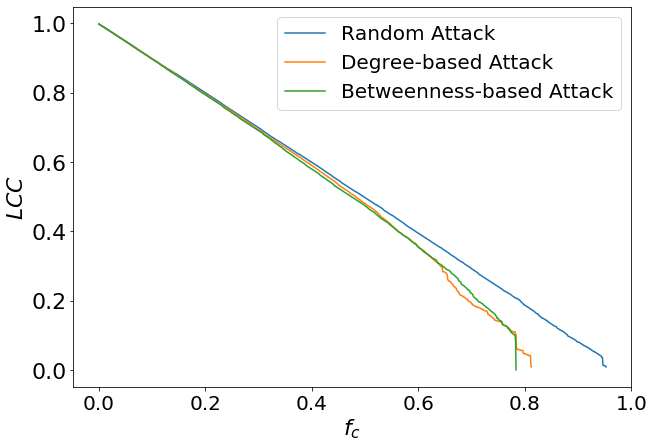

In [40]:
x=[k[0] for k in resilience_random]
y=[k[1] for k in resilience_random]

x1=[k[0] for k in resilience_deg]
y1=[k[1] for k in resilience_deg]

x2=[k[0] for k in resilience_betw]
y2=[k[1] for k in resilience_betw]

plt.figure(figsize=(10,7))

plt.plot(x,y, label='Random Attack')
plt.plot(x1,y1, label='Degree-based Attack')
plt.plot(x2,y2, label='Betweenness-based Attack')

plt.xlabel('$f_{c}$', fontsize=22)
plt.ylabel('$LCC$', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)

plt.legend(loc='upper right', fontsize=20)

## Stochastic SIR Epidemic on Static Network

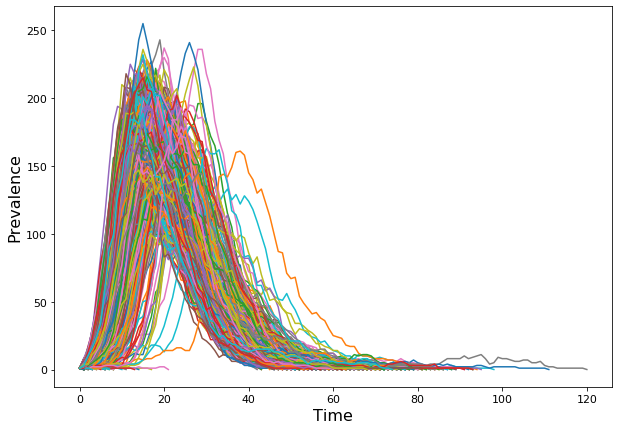

In [41]:
# Model Parameters
mu = 0.2           # Recovery rate 
lambd = 0.01       # Transmission rate per contact

# Simulation Parameters
nrun = 1000        # Number of runs

# Multi-Run Simulation
runs = soc.network_SIR_multirun_simulation(G, nrun = nrun, lambd = lambd, mu = mu)

# Set figure size 
plt.figure(figsize=(10,7))

# Plot the ensemble of trajectories
soc.plot_ensemble(runs)

### $\lambda$-Sensitivity of Final Epidemic Size

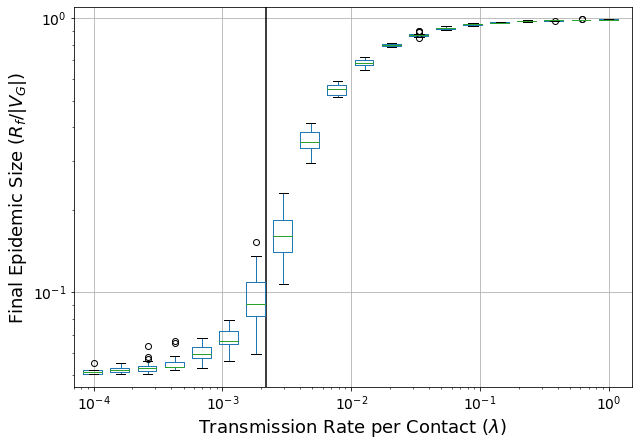

In [42]:
# Perform lambda-sensitivity analysis of final epidemic size (normalized attack rate) 
data = soc.network_SIR_finalsize_lambda_sensitivity(G, mu = mu, rho = 0.05, # rho = initial fraction infected
                                                    lambda_min = 0.0001, lambda_max = 1.0, 
                                                    nruns = 20)
# Show sensitivity dataset
data 

# Set figure size 
plt.figure(figsize=(10,7))

# Display a boxplot with final epidemic size vs. transmission rate per edge/contact
soc.boxplot_finalsize_lambda_sensitivity(G, mu = mu, data = data, 
                                         ymin = 0.045, ymax= 1.1,
                                         xlim = (0.00007, 1.5) )

## Community Detection 

### Modularity | `Gephi`

* **Algorithm**: Vincent D Blondel et al. [Fast unfolding of communities in large networks](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta), *Journal of Statistical Mechanics: Theory and Experiment* (2008).

* **Resolution**: R. Lambiotte et al.[Barahona Laplacian Dynamics and Multiscale Modular Structure in Networks](https://arxiv.org/abs/0812.1770), *arXiv pre-print* (2009).

#### Inputs 

* Randomize: On
* Use edge weights: On

#### Low Resolution (0.5)

* Modularity: 0.390
* Modularity with resolution: 0.131
* Number of Communities: 13

![Modularity Report](./Gephi/Modularity_0.5/communities-size-distribution.png) <img src="./Images/Twitter/@PietroMonticone0.5.png" alt="Visualization with color coded communities" width="550"/>

#### Medium Resolution (1.2)

* Modularity: 0.442
* Modularity with resolution: 0.582
* Number of Communities: 7

![Modularity Report](./Gephi/Modularity_1.2/communities-size-distribution.png) <img src="./Images/Twitter/@PietroMonticone1.2.png" alt="Visualization with color coded communities" width="450"/>

#### High Resolution (3.9)

* Modularity: 0.000
* Modularity with resolution: 2.900
* Number of Communities: 3

![Modularity Report](./Gephi/Modularity_3.9/communities-size-distribution.png) <img src="./Images/Twitter/@PietroMonticone3.9.png" alt="Visualization with color coded communities" width="450"/>

### Girvan-Newman Clustering 

1. Create a partition sequence
  1. Calculate the betweenness centrality for all links.
  2. Remove the link with largest betweenness and create a partition using connected components.
  3. Recalculate the betweenness centrality of the links of the resulting graph.
  4. Repeat from step B until no links remain.
2. Evaluate each partition in the sequence and choose the one with the highest modularity.

In [43]:
def updateGraph1(G):
    ebw = nc.edge_betweenness(G)
    maxs = 0
    for k, v in ebw.items():
        if maxs < v:
            medge, maxs = k, v
    G.remove_edge(medge[0],medge[1])

def updateGraph2(G):
    ebw = nc.edge_betweenness(G)
    edge_list=sorted(ebw.items(), key=itemgetter(1))
    medge=edge_list[-1][0]
    G.remove_edge(medge[0],medge[1])

As expected the Girvan-Nirvan algorithm doesn't scale well with edge cardinality of the graph.

In [44]:
G_weakly_cc = list(nx.weakly_connected_components(G))
GWCC = list(G_weakly_cc[0])
WCC = G.subgraph(GWCC)

# Resolution: 1.2
# Modularity: 0.442
# Number of Communities: 7
    
n_wcc = nx.number_weakly_connected_components(WCC)

while nx.number_weakly_connected_components(WCC) < 8:
    updateGraph2(WCC)
    if nx.number_weakly_connected_components(WCC) !=  n_wcc:
        print(nx.number_weakly_connected_components(WCC))
        n_wcc = nx.number_weakly_connected_components(WCC)

NetworkXError: Frozen graph can't be modified